# Home Credit Default Risk - Model Experiments
## Production-Ready Credit Risk Modeling for Fintech

This notebook contains end-to-end code for building credit default prediction models suitable for fintech companies.

### Competition Overview
- **Goal**: Predict loan default risk
- **Metric**: ROC AUC
- **Challenge**: Many clients have insufficient credit history

### Notebook Structure
1. Environment Setup & Data Loading
2. Exploratory Data Analysis
3. Feature Engineering
4. Data Preprocessing
5. Model Training & Validation
6. Model Evaluation & Interpretation
7. Final Predictions

## 1. Environment Setup & Library Imports

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import gc
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb
import xgboost as xgb

# Feature importance
import shap

# Utilities
import os
from datetime import datetime

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Libraries imported successfully!")
print(f"Notebook executed on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Libraries imported successfully!
Notebook executed on: 2026-01-30 16:47:51


## 2. Data Loading

The Home Credit dataset consists of multiple tables:
- **application_train/test**: Main training/test data
- **bureau**: Credit bureau data
- **bureau_balance**: Monthly bureau balances
- **previous_application**: Previous applications
- **POS_CASH_balance**: Point of sale and cash loans
- **credit_card_balance**: Credit card balances
- **installments_payments**: Repayment history

In [3]:
# Define data path - update this to your actual data directory
DATA_PATH = '../raw/'

def load_data(verbose=True):
    """
    Load all Home Credit dataset files
    
    Returns:
        dict: Dictionary containing all dataframes
    """
    data = {}
    
    # Main application data
    if verbose:
        print("Loading application_train.csv...")
    data['train'] = pd.read_csv(f'{DATA_PATH}application_train.csv')
    
    if verbose:
        print("Loading application_test.csv...")
    data['test'] = pd.read_csv(f'{DATA_PATH}application_test.csv')
    
    # Supplementary data
    if verbose:
        print("Loading bureau.csv...")
    data['bureau'] = pd.read_csv(f'{DATA_PATH}bureau.csv')
    
    if verbose:
        print("Loading bureau_balance.csv...")
    data['bureau_balance'] = pd.read_csv(f'{DATA_PATH}bureau_balance.csv')
    
    if verbose:
        print("Loading previous_application.csv...")
    data['prev_app'] = pd.read_csv(f'{DATA_PATH}previous_application.csv')
    
    if verbose:
        print("Loading POS_CASH_balance.csv...")
    data['pos_cash'] = pd.read_csv(f'{DATA_PATH}POS_CASH_balance.csv')
    
    if verbose:
        print("Loading credit_card_balance.csv...")
    data['credit_card'] = pd.read_csv(f'{DATA_PATH}credit_card_balance.csv')
    
    if verbose:
        print("Loading installments_payments.csv...")
    data['installments'] = pd.read_csv(f'{DATA_PATH}installments_payments.csv')
    
    if verbose:
        print("\nData loaded successfully!")
        print(f"Train shape: {data['train'].shape}")
        print(f"Test shape: {data['test'].shape}")
    
    return data

# Load all data
data = load_data()


Loading application_train.csv...
Loading application_test.csv...
Loading bureau.csv...
Loading bureau_balance.csv...
Loading previous_application.csv...
Loading POS_CASH_balance.csv...
Loading credit_card_balance.csv...
Loading installments_payments.csv...

Data loaded successfully!
Train shape: (307511, 122)
Test shape: (48744, 121)


In [4]:
# Quick overview of main training data
print("="*80)
print("TRAINING DATA OVERVIEW")
print("="*80)
print(f"\nShape: {data['train'].shape}")
print(f"\nTarget Distribution:")
print(data['train']['TARGET'].value_counts())
print(f"\nDefault Rate: {data['train']['TARGET'].mean():.2%}")
print(f"\nFirst few rows:")
data['train'].head()

TRAINING DATA OVERVIEW

Shape: (307511, 122)

Target Distribution:
TARGET
0    282686
1     24825
Name: count, dtype: int64

Default Rate: 8.07%

First few rows:


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Check data types and missing values
def data_overview(df, name='DataFrame'):
    """
    Print comprehensive overview of a dataframe
    """
    print(f"\n{'='*80}")
    print(f"{name} OVERVIEW")
    print(f"{'='*80}")
    print(f"\nShape: {df.shape[0]:,} rows x {df.shape[1]} columns")
    
    print(f"\nData Types:")
    print(df.dtypes.value_counts())
    
    print(f"\nMemory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Missing values
    missing = df.isnull().sum()
    missing_pct = 100 * missing / len(df)
    missing_df = pd.DataFrame({
        'Missing_Count': missing,
        'Percentage': missing_pct
    }).sort_values('Percentage', ascending=False)
    
    print(f"\nColumns with Missing Values (Top 10):")
    print(missing_df[missing_df['Percentage'] > 0].head(10))
    
    return missing_df

# Analyze training data
missing_train = data_overview(data['train'], 'Training Data')


Training Data OVERVIEW

Shape: 307,511 rows x 122 columns

Data Types:
float64    65
int64      41
object     16
Name: count, dtype: int64

Memory Usage: 504.99 MB

Columns with Missing Values (Top 10):
                          Missing_Count  Percentage
COMMONAREA_AVG                   214865   69.872297
COMMONAREA_MODE                  214865   69.872297
COMMONAREA_MEDI                  214865   69.872297
NONLIVINGAPARTMENTS_MEDI         213514   69.432963
NONLIVINGAPARTMENTS_MODE         213514   69.432963
NONLIVINGAPARTMENTS_AVG          213514   69.432963
FONDKAPREMONT_MODE               210295   68.386172
LIVINGAPARTMENTS_AVG             210199   68.354953
LIVINGAPARTMENTS_MEDI            210199   68.354953
LIVINGAPARTMENTS_MODE            210199   68.354953


## 3. Exploratory Data Analysis (EDA)

In [ ]:
# Target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Count plot
data['train']['TARGET'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Target Distribution (Counts)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Target (0: No Default, 1: Default)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['No Default (0)', 'Default (1)'], rotation=0)

# Add percentages
for i, v in enumerate(data['train']['TARGET'].value_counts()):
    pct = 100 * v / len(data['train'])
    axes[0].text(i, v + 1000, f'{pct:.1f}%', ha='center', fontweight='bold')

# Pie chart
colors = ['green', 'red']
data['train']['TARGET'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                                             colors=colors, startangle=90)
axes[1].set_title('Target Distribution (Percentage)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')
axes[1].legend(['No Default', 'Default'], loc='best')

plt.tight_layout()
plt.show()

print(f"\nClass Imbalance Ratio: {data['train']['TARGET'].value_counts()[0] / data['train']['TARGET'].value_counts()[1]:.2f}:1")

In [ ]:
# Analyze numerical features
def analyze_numerical_features(df, target='TARGET', top_n=15):
    """
    Analyze numerical features and their relationship with target
    """
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if target in numerical_cols:
        numerical_cols.remove(target)
    if 'SK_ID_CURR' in numerical_cols:
        numerical_cols.remove('SK_ID_CURR')
    
    # Calculate correlations with target
    correlations = df[numerical_cols + [target]].corr()[target].drop(target)
    correlations = correlations.abs().sort_values(ascending=False)
    
    # Plot top correlations
    fig, ax = plt.subplots(figsize=(12, 6))
    correlations.head(top_n).plot(kind='barh', ax=ax, color='steelblue')
    ax.set_title(f'Top {top_n} Features by Absolute Correlation with Target', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Absolute Correlation')
    ax.set_ylabel('Features')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return correlations

correlations = analyze_numerical_features(data['train'])
print("\nTop 10 Correlated Features:")
print(correlations.head(10))

In [ ]:
# Analyze key numerical features distribution by target
key_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 
                'DAYS_EMPLOYED', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL']

fig, axes = plt.subplots(4, 2, figsize=(16, 16))
axes = axes.ravel()

for idx, col in enumerate(key_features):
    if col in data['train'].columns:
        # Filter out extreme values for better visualization
        non_null_data = data['train'][data['train'][col].notnull()]
        
        for target_val in [0, 1]:
            subset = non_null_data[non_null_data['TARGET'] == target_val][col]
            axes[idx].hist(subset, bins=50, alpha=0.6, 
                          label=f'Target={target_val}',
                          density=True)
        
        axes[idx].set_title(col, fontweight='bold')
        axes[idx].set_xlabel('Value')
        axes[idx].set_ylabel('Density')
        axes[idx].legend()

plt.tight_layout()
plt.show()

Found 16 categorical features

Categorical columns: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']...


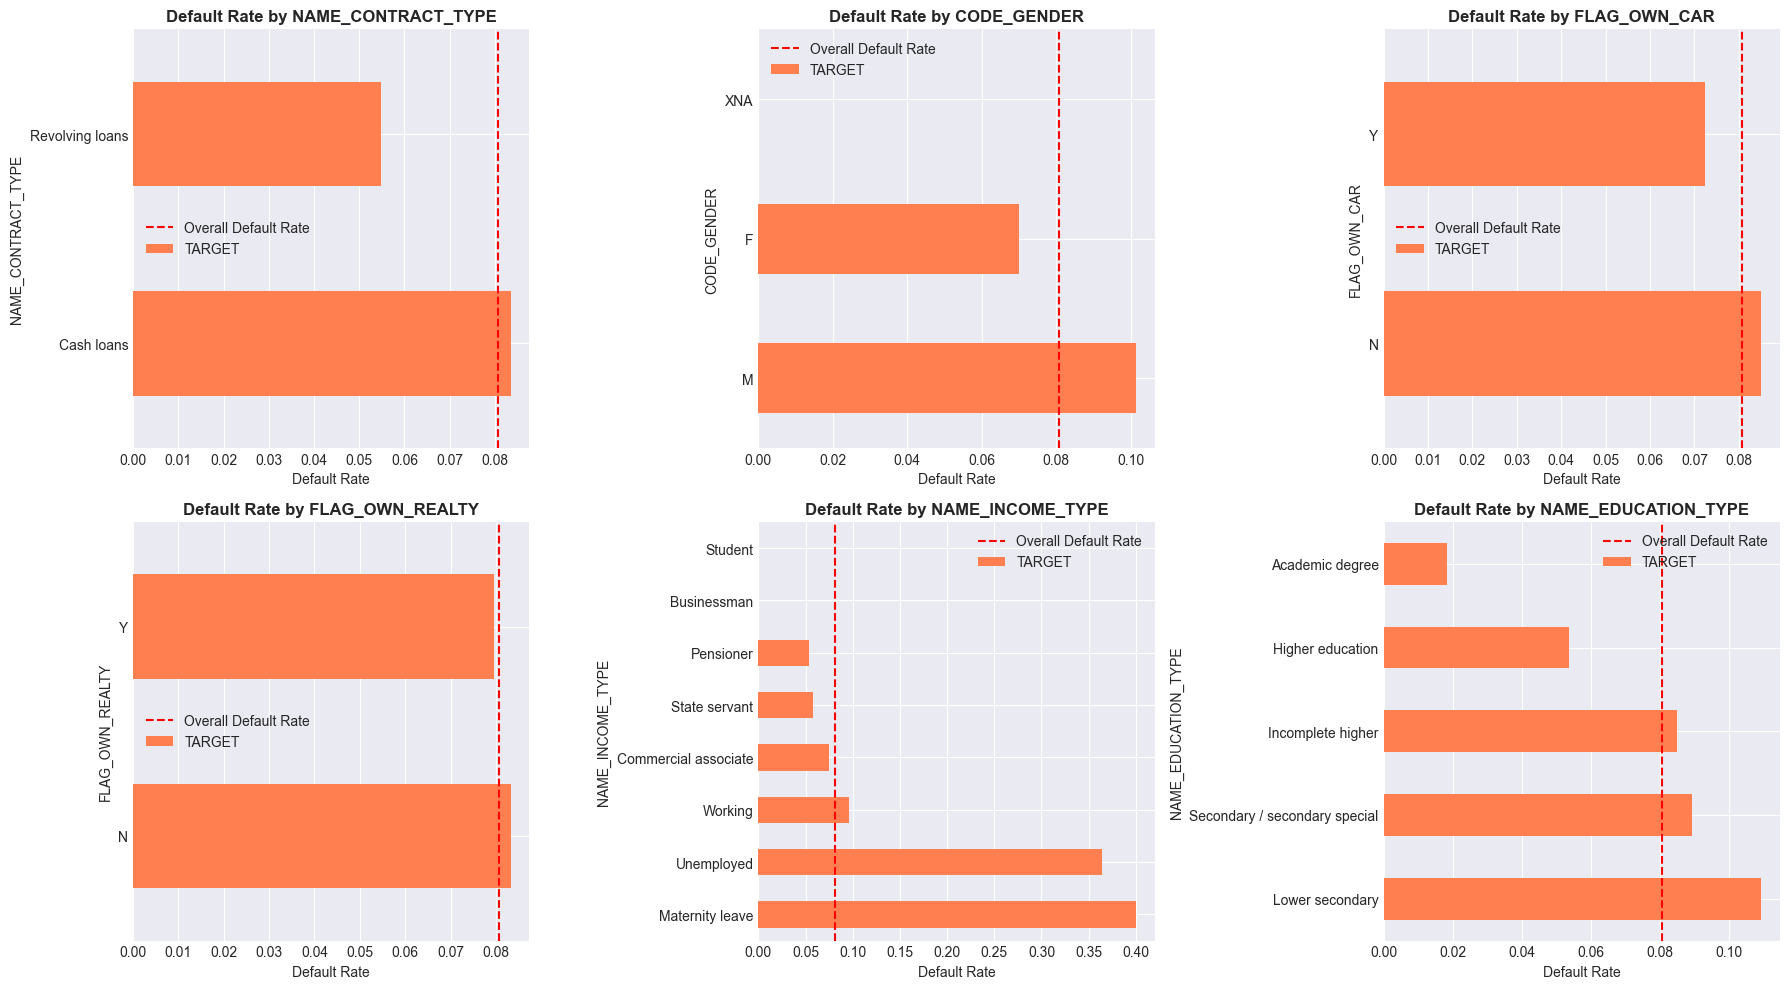

In [6]:
# Analyze categorical features
def analyze_categorical_features(df, target='TARGET', top_n=10):
    """
    Analyze categorical features and their relationship with target
    """
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    print(f"Found {len(categorical_cols)} categorical features")
    print(f"\nCategorical columns: {categorical_cols[:10]}...")
    
    # Analyze key categorical features
    key_cats = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 
                'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
                'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']
    
    key_cats = [col for col in key_cats if col in categorical_cols]
    
    # Calculate default rates by category
    default_rates = {}
    for col in key_cats:
        default_rates[col] = df.groupby(col)[target].mean().sort_values(ascending=False)
    
    return default_rates, key_cats

default_rates, key_cats = analyze_categorical_features(data['train'])

# Plot default rates for key categorical variables
n_plots = min(6, len(key_cats))
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, col in enumerate(key_cats[:n_plots]):
    default_rates[col].plot(kind='barh', ax=axes[idx], color='coral')
    axes[idx].set_title(f'Default Rate by {col}', fontweight='bold')
    axes[idx].set_xlabel('Default Rate')
    axes[idx].axvline(data['train']['TARGET'].mean(), color='red', 
                      linestyle='--', label='Overall Default Rate')
    axes[idx].legend()

plt.tight_layout()
plt.show()

## 4. Feature Engineering

Creating advanced features for credit risk modeling

In [ ]:
def engineer_application_features(df):
    """
    Engineer features from application data
    
    Args:
        df: Application dataframe
    
    Returns:
        DataFrame with engineered features
    """
    df = df.copy()
    
    print("Engineering application features...")
    
    # Age features (DAYS_BIRTH is negative)
    df['AGE_YEARS'] = -df['DAYS_BIRTH'] / 365
    df['AGE_GROUP'] = pd.cut(df['AGE_YEARS'], bins=[0, 25, 35, 45, 55, 100],
                              labels=['18-25', '26-35', '36-45', '46-55', '55+'])
    
    # Employment features (DAYS_EMPLOYED is negative, but has anomalies)
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    df['EMPLOYMENT_YEARS'] = -df['DAYS_EMPLOYED'] / 365
    df['EMPLOYMENT_YEARS'].fillna(0, inplace=True)
    
    # Income features
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['INCOME_PER_CHILD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
    
    # Credit features
    df['CREDIT_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    df['ANNUITY_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['CREDIT_TERM'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['CREDIT_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    
    # Payment burden
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    df['DAYS_EMPLOYED_PERCENT'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    
    # External source combinations
    df['EXT_SOURCE_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['EXT_SOURCE_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    df['EXT_SOURCE_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    
    # Document flags
    doc_cols = [col for col in df.columns if 'FLAG_DOCUMENT' in col]
    df['DOCUMENT_COUNT'] = df[doc_cols].sum(axis=1)
    
    # Contact information
    df['HAS_MOBILE'] = (df['FLAG_MOBIL'] == 1).astype(int)
    df['HAS_WORK_PHONE'] = (df['FLAG_WORK_PHONE'] == 1).astype(int)
    df['HAS_PHONE'] = (df['FLAG_PHONE'] == 1).astype(int)
    df['HAS_EMAIL'] = (df['FLAG_EMAIL'] == 1).astype(int)
    df['CONTACT_COUNT'] = df['HAS_MOBILE'] + df['HAS_WORK_PHONE'] + df['HAS_PHONE'] + df['HAS_EMAIL']
    
    # Region features
    df['REGION_RATING_DIFF'] = df['REGION_RATING_CLIENT'] - df['REGION_RATING_CLIENT_W_CITY']
    
    # Enquiry features (negative days)
    df['DAYS_LAST_PHONE_CHANGE'] = df['DAYS_LAST_PHONE_CHANGE'].abs()
    
    print(f"Engineered {len([col for col in df.columns if col not in data['train'].columns])} new features")
    
    return df

# Apply feature engineering
train_fe = engineer_application_features(data['train'])
test_fe = engineer_application_features(data['test'])

print(f"\nNew shape - Train: {train_fe.shape}, Test: {test_fe.shape}")

In [ ]:
def aggregate_bureau_features(df_bureau, df_bureau_balance):
    """
    Aggregate features from bureau and bureau balance data
    
    Args:
        df_bureau: Bureau dataframe
        df_bureau_balance: Bureau balance dataframe
    
    Returns:
        Aggregated features by SK_ID_CURR
    """
    print("Aggregating bureau features...")
    
    # Bureau balance aggregations
    bb_agg = df_bureau_balance.groupby('SK_ID_BUREAU').agg({
        'MONTHS_BALANCE': ['min', 'max', 'mean'],
        'STATUS': lambda x: (x == 'C').sum()  # Count of closed statuses
    })
    bb_agg.columns = ['_'.join(col).upper() for col in bb_agg.columns]
    bb_agg.reset_index(inplace=True)
    
    # Merge with bureau
    bureau = df_bureau.merge(bb_agg, on='SK_ID_BUREAU', how='left')
    
    # Bureau aggregations by client
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({
        'SK_ID_BUREAU': 'count',  # Number of previous credits
        'DAYS_CREDIT': ['min', 'max', 'mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': 'max',
        'CNT_CREDIT_PROLONG': 'sum',
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': 'mean',
        'DAYS_CREDIT_UPDATE': ['min', 'max', 'mean'],
        'AMT_ANNUITY': ['max', 'mean']
    })
    
    bureau_agg.columns = ['BUREAU_' + '_'.join(col).upper() for col in bureau_agg.columns]
    
    # Active credits
    active = bureau[bureau['CREDIT_ACTIVE'] == 'Active'].groupby('SK_ID_CURR').agg({
        'SK_ID_BUREAU': 'count',
        'AMT_CREDIT_SUM_DEBT': 'sum'
    })
    active.columns = ['BUREAU_ACTIVE_COUNT', 'BUREAU_ACTIVE_DEBT']
    
    # Closed credits
    closed = bureau[bureau['CREDIT_ACTIVE'] == 'Closed'].groupby('SK_ID_CURR').agg({
        'SK_ID_BUREAU': 'count',
        'DAYS_CREDIT': 'max'
    })
    closed.columns = ['BUREAU_CLOSED_COUNT', 'BUREAU_CLOSED_DAYS_CREDIT_MAX']
    
    # Merge all bureau features
    bureau_agg = bureau_agg.merge(active, left_index=True, right_index=True, how='left')
    bureau_agg = bureau_agg.merge(closed, left_index=True, right_index=True, how='left')
    
    bureau_agg.reset_index(inplace=True)
    
    print(f"Created {len(bureau_agg.columns)-1} bureau features")
    
    return bureau_agg

# Aggregate bureau features
bureau_agg = aggregate_bureau_features(data['bureau'], data['bureau_balance'])

# Merge with main data
train_fe = train_fe.merge(bureau_agg, on='SK_ID_CURR', how='left')
test_fe = test_fe.merge(bureau_agg, on='SK_ID_CURR', how='left')

print(f"\nNew shape after bureau merge - Train: {train_fe.shape}, Test: {test_fe.shape}")

In [ ]:
def aggregate_previous_applications(df_prev):
    """
    Aggregate features from previous applications
    """
    print("Aggregating previous application features...")
    
    # Basic aggregations
    prev_agg = df_prev.groupby('SK_ID_CURR').agg({
        'SK_ID_PREV': 'count',
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum']
    })
    
    prev_agg.columns = ['PREV_' + '_'.join(col).upper() for col in prev_agg.columns]
    
    # Categorical aggregations
    # Approved applications
    approved = df_prev[df_prev['NAME_CONTRACT_STATUS'] == 'Approved'].groupby('SK_ID_CURR').agg({
        'SK_ID_PREV': 'count',
        'AMT_CREDIT': 'sum'
    })
    approved.columns = ['PREV_APPROVED_COUNT', 'PREV_APPROVED_CREDIT']
    
    # Refused applications
    refused = df_prev[df_prev['NAME_CONTRACT_STATUS'] == 'Refused'].groupby('SK_ID_CURR').agg({
        'SK_ID_PREV': 'count'
    })
    refused.columns = ['PREV_REFUSED_COUNT']
    
    # Merge
    prev_agg = prev_agg.merge(approved, left_index=True, right_index=True, how='left')
    prev_agg = prev_agg.merge(refused, left_index=True, right_index=True, how='left')
    
    prev_agg.reset_index(inplace=True)
    
    print(f"Created {len(prev_agg.columns)-1} previous application features")
    
    return prev_agg

# Aggregate previous applications
prev_agg = aggregate_previous_applications(data['prev_app'])

# Merge with main data
train_fe = train_fe.merge(prev_agg, on='SK_ID_CURR', how='left')
test_fe = test_fe.merge(prev_agg, on='SK_ID_CURR', how='left')

print(f"\nNew shape after prev_app merge - Train: {train_fe.shape}, Test: {test_fe.shape}")

# Clear memory
del prev_agg
gc.collect()

In [8]:
# Start with application data as the base
train_fe = data['train'].copy()
test_fe  = data['test'].copy()

print("Initial shapes - Train:", train_fe.shape, "Test:", test_fe.shape)


Initial shapes - Train: (307511, 122) Test: (48744, 121)


In [9]:
def aggregate_installments(df_inst):
    """
    Aggregate features from installment payments
    """
    print("Aggregating installment features...")
    
    # Payment difference and delay
    df_inst['PAYMENT_DIFF'] = df_inst['AMT_PAYMENT'] - df_inst['AMT_INSTALMENT']
    df_inst['PAYMENT_RATIO'] = df_inst['AMT_PAYMENT'] / df_inst['AMT_INSTALMENT']
    df_inst['DAYS_PAYMENT_DELAY'] = df_inst['DAYS_ENTRY_PAYMENT'] - df_inst['DAYS_INSTALMENT']
    
    # Aggregations
    inst_agg = df_inst.groupby('SK_ID_CURR').agg({
        'SK_ID_PREV': 'count',
        'NUM_INSTALMENT_NUMBER': ['max', 'mean'],
        'NUM_INSTALMENT_VERSION': ['max'],
        'DAYS_INSTALMENT': ['min', 'max', 'mean'],
        'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean'],
        'AMT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'PAYMENT_DIFF': ['min', 'max', 'mean', 'sum'],
        'PAYMENT_RATIO': ['min', 'max', 'mean'],
        'DAYS_PAYMENT_DELAY': ['min', 'max', 'mean']
    })
    
    inst_agg.columns = ['INST_' + '_'.join(col).upper() for col in inst_agg.columns]
    inst_agg.reset_index(inplace=True)
    
    print(f"Created {len(inst_agg.columns)-1} installment features")
    
    return inst_agg

# Aggregate installments
inst_agg = aggregate_installments(data['installments'])

# Merge with main data
train_fe = train_fe.merge(inst_agg, on='SK_ID_CURR', how='left')
test_fe = test_fe.merge(inst_agg, on='SK_ID_CURR', how='left')

print(f"\nNew shape after installments merge - Train: {train_fe.shape}, Test: {test_fe.shape}")

# Clear memory
del inst_agg
gc.collect()

Aggregating installment features...
Created 28 installment features

New shape after installments merge - Train: (307511, 150), Test: (48744, 149)


8440

## 5. Data Preprocessing

In [11]:
# Drop ID and target to get feature matrix
X = train_fe.drop(columns=["SK_ID_CURR","TARGET"])
y = train_fe["TARGET"]

# For test set, drop ID only
X_test = test_fe.drop(columns=["SK_ID_CURR"])


In [12]:
def preprocess_data(train_df, test_df, target='TARGET'):
    """
    Preprocess data for modeling
    
    Steps:
    1. Handle categorical variables
    2. Handle missing values
    3. Remove highly correlated features
    4. Feature selection
    """
    print("Preprocessing data...")
    
    # Separate target
    y_train = train_df[target]
    train_df = train_df.drop(columns=[target])
    
    # Identify feature types
    categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Remove ID column
    id_col = 'SK_ID_CURR'
    train_ids = train_df[id_col]
    test_ids = test_df[id_col]
    
    if id_col in numerical_cols:
        numerical_cols.remove(id_col)
    
    print(f"\nFeature counts:")
    print(f"  Categorical: {len(categorical_cols)}")
    print(f"  Numerical: {len(numerical_cols)}")
    
    # Encode categorical variables
    print("\nEncoding categorical variables...")
    le = LabelEncoder()
    
    for col in categorical_cols:
        # Combine train and test for consistent encoding
        combined = pd.concat([train_df[col], test_df[col]], axis=0)
        combined_encoded = le.fit_transform(combined.astype(str))
        
        train_df[col] = combined_encoded[:len(train_df)]
        test_df[col] = combined_encoded[len(train_df):]
    
    # Drop ID column
    train_df = train_df.drop(columns=[id_col])
    test_df = test_df.drop(columns=[id_col])
    
    # Align train and test columns
    train_df, test_df = train_df.align(test_df, join='inner', axis=1)
    
    print(f"\nFinal shapes:")
    print(f"  Train: {train_df.shape}")
    print(f"  Test: {test_df.shape}")
    
    # Handle missing values
    print("\nHandling missing values...")
    missing_pct = train_df.isnull().sum() / len(train_df) * 100
    high_missing_cols = missing_pct[missing_pct > 70].index.tolist()
    
    print(f"Dropping {len(high_missing_cols)} columns with >70% missing values")
    train_df = train_df.drop(columns=high_missing_cols)
    test_df = test_df.drop(columns=high_missing_cols)
    
    # Impute remaining missing values
    # For numerical: use median
    # For categorical (now encoded): use most frequent
    for col in train_df.columns:
        if train_df[col].isnull().sum() > 0:
            fill_value = train_df[col].median() if col in numerical_cols else train_df[col].mode()[0]
            train_df[col].fillna(fill_value, inplace=True)
            test_df[col].fillna(fill_value, inplace=True)
    
    print(f"\nPreprocessing complete!")
    print(f"  Final train shape: {train_df.shape}")
    print(f"  Final test shape: {test_df.shape}")
    
    return train_df, test_df, y_train, train_ids, test_ids

# Preprocess data
X_train, X_test, y_train, train_ids, test_ids = preprocess_data(train_fe, test_fe)

Preprocessing data...

Feature counts:
  Categorical: 16
  Numerical: 132

Encoding categorical variables...

Final shapes:
  Train: (307511, 148)
  Test: (48744, 148)

Handling missing values...
Dropping 0 columns with >70% missing values

Preprocessing complete!
  Final train shape: (307511, 148)
  Final test shape: (48744, 148)


In [13]:
# Check for remaining issues
print("Data quality check:")
print(f"  Train nulls: {X_train.isnull().sum().sum()}")
print(f"  Test nulls: {X_test.isnull().sum().sum()}")
print(f"  Train infinites: {np.isinf(X_train.select_dtypes(include=[np.number])).sum().sum()}")
print(f"  Test infinites: {np.isinf(X_test.select_dtypes(include=[np.number])).sum().sum()}")

# Replace infinites with NaN and then fill
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

# Fill any remaining NaN values
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())  # Use train median for test

print("\nData ready for modeling!")

Data quality check:
  Train nulls: 0
  Test nulls: 0
  Train infinites: 39
  Test infinites: 2

Data ready for modeling!


## 6. Model Training & Validation

Training multiple models with cross-validation

In [15]:
# Split data for validation
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train
)

print(f"Training set: {X_tr.shape}")
print(f"Validation set: {X_val.shape}")
print(f"\nTarget distribution in training:")
print(y_tr.value_counts(normalize=True))
print(f"\nTarget distribution in validation:")
print(y_val.value_counts(normalize=True))

Training set: (246008, 148)
Validation set: (61503, 148)

Target distribution in training:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

Target distribution in validation:
TARGET
0    0.919272
1    0.080728
Name: proportion, dtype: float64


In [16]:
# Define models
models = {}
scores = {}

# 1. Logistic Regression (Baseline)
print("Training Logistic Regression...")
lr = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_STATE,
    class_weight='balanced',
    n_jobs=-1
)

# Scale features for logistic regression
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)

lr.fit(X_tr_scaled, y_tr)
lr_pred = lr.predict_proba(X_val_scaled)[:, 1]
lr_score = roc_auc_score(y_val, lr_pred)

models['Logistic Regression'] = lr
scores['Logistic Regression'] = lr_score

print(f"  Validation ROC AUC: {lr_score:.4f}")

Training Logistic Regression...
  Validation ROC AUC: 0.7557


In [17]:
# 2. Random Forest
print("\nTraining Random Forest...")
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)

rf.fit(X_tr, y_tr)
rf_pred = rf.predict_proba(X_val)[:, 1]
rf_score = roc_auc_score(y_val, rf_pred)

models['Random Forest'] = rf
scores['Random Forest'] = rf_score

print(f"  Validation ROC AUC: {rf_score:.4f}")


Training Random Forest...
  Validation ROC AUC: 0.7480


In [18]:
# 3. LightGBM (Best for production fintech models)
print("\nTraining LightGBM...")

# Calculate scale_pos_weight for imbalanced data
scale_pos_weight = (y_tr == 0).sum() / (y_tr == 1).sum()

lgbm_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': -1,
    'min_child_samples': 20,
    'scale_pos_weight': scale_pos_weight,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'verbose': -1
}

# Create datasets
lgb_train = lgb.Dataset(X_tr, y_tr)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

# Train with early stopping
lgbm = lgb.train(
    lgbm_params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

lgbm_pred = lgbm.predict(X_val, num_iteration=lgbm.best_iteration)
lgbm_score = roc_auc_score(y_val, lgbm_pred)

models['LightGBM'] = lgbm
scores['LightGBM'] = lgbm_score

print(f"\n  Best iteration: {lgbm.best_iteration}")
print(f"  Validation ROC AUC: {lgbm_score:.4f}")


Training LightGBM...
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.790226	valid's auc: 0.76669
[200]	train's auc: 0.811847	valid's auc: 0.770696
[300]	train's auc: 0.828932	valid's auc: 0.771706
[400]	train's auc: 0.843583	valid's auc: 0.771832
Early stopping, best iteration is:
[366]	train's auc: 0.838806	valid's auc: 0.772134

  Best iteration: 366
  Validation ROC AUC: 0.7721


In [19]:
# 4. XGBoost
print("\nTraining XGBoost...")

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'scale_pos_weight': scale_pos_weight,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'verbosity': 0
}

# Create DMatrix
dtrain = xgb.DMatrix(X_tr, label=y_tr)
dval = xgb.DMatrix(X_val, label=y_val)

# Train with early stopping
xgbm = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dval, 'valid')],
    early_stopping_rounds=50,
    verbose_eval=100
)

xgb_pred = xgbm.predict(dval, iteration_range=(0, xgbm.best_iteration + 1))
xgb_score = roc_auc_score(y_val, xgb_pred)

models['XGBoost'] = xgbm
scores['XGBoost'] = xgb_score

print(f"\n  Best iteration: {xgbm.best_iteration}")
print(f"  Validation ROC AUC: {xgb_score:.4f}")


Training XGBoost...
[0]	train-auc:0.69016	valid-auc:0.68144
[100]	train-auc:0.80113	valid-auc:0.76529
[200]	train-auc:0.82745	valid-auc:0.77013
[300]	train-auc:0.84684	valid-auc:0.77168
[347]	train-auc:0.85454	valid-auc:0.77172

  Best iteration: 297
  Validation ROC AUC: 0.7717



MODEL COMPARISON
              Model  ROC AUC
           LightGBM 0.772134
            XGBoost 0.771749
Logistic Regression 0.755714
      Random Forest 0.747983


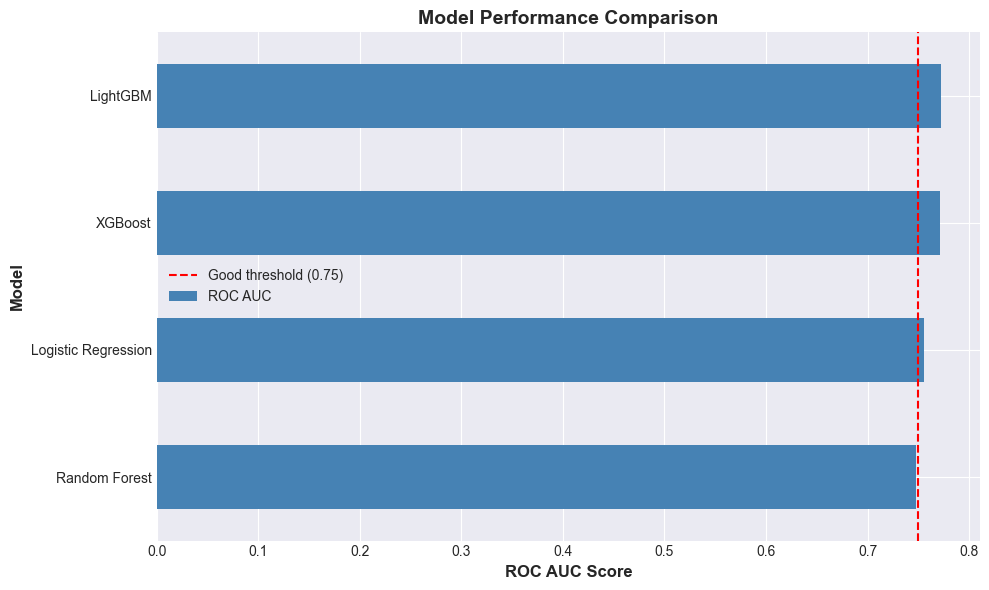


Best Model: LightGBM
Best ROC AUC: 0.7721


In [20]:
# Compare all models
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

scores_df = pd.DataFrame({
    'Model': list(scores.keys()),
    'ROC AUC': list(scores.values())
}).sort_values('ROC AUC', ascending=False)

print(scores_df.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))
scores_df.plot(x='Model', y='ROC AUC', kind='barh', ax=ax, color='steelblue', legend=False)
ax.set_xlabel('ROC AUC Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Model', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.axvline(0.75, color='red', linestyle='--', label='Good threshold (0.75)')
ax.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

best_model_name = scores_df.iloc[0]['Model']
print(f"\nBest Model: {best_model_name}")
print(f"Best ROC AUC: {scores_df.iloc[0]['ROC AUC']:.4f}")

## 7. Model Evaluation & Interpretation

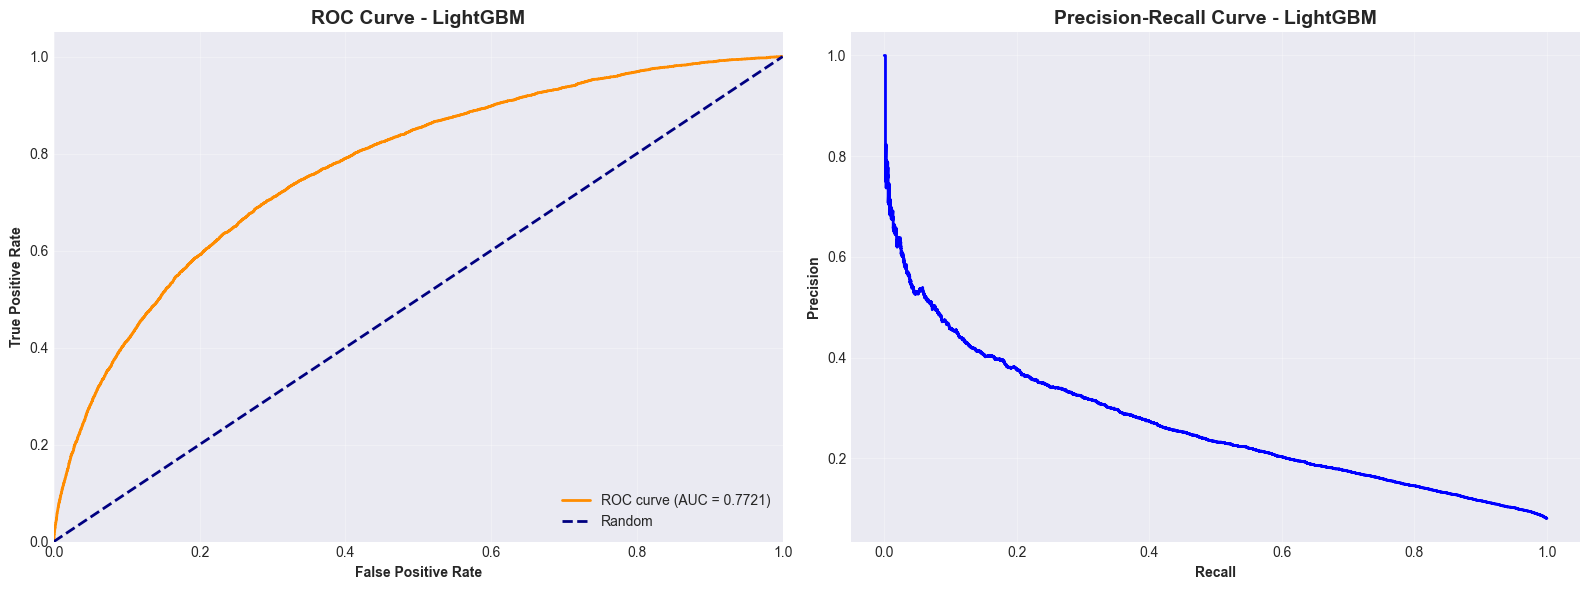

In [21]:
# Detailed evaluation of best model (LightGBM)
best_model = models['LightGBM']
best_pred = lgbm_pred

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, best_pred)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {lgbm_score:.4f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontweight='bold')
axes[0].set_ylabel('True Positive Rate', fontweight='bold')
axes[0].set_title('ROC Curve - LightGBM', fontsize=14, fontweight='bold')
axes[0].legend(loc="lower right")
axes[0].grid(alpha=0.3)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, best_pred)
axes[1].plot(recall, precision, color='blue', lw=2)
axes[1].set_xlabel('Recall', fontweight='bold')
axes[1].set_ylabel('Precision', fontweight='bold')
axes[1].set_title('Precision-Recall Curve - LightGBM', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

Optimal Threshold: 0.4823
TPR at optimal threshold: 0.7029
FPR at optimal threshold: 0.2924


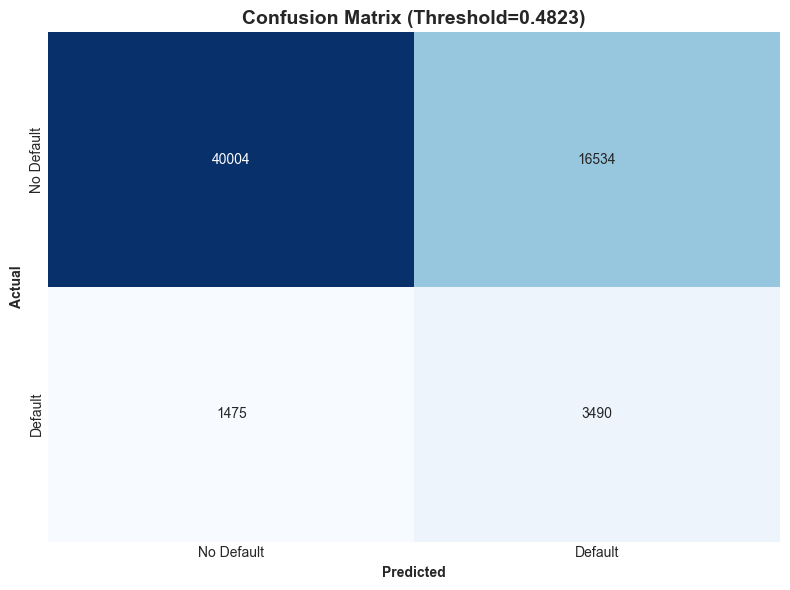


Classification Report:
              precision    recall  f1-score   support

  No Default       0.96      0.71      0.82     56538
     Default       0.17      0.70      0.28      4965

    accuracy                           0.71     61503
   macro avg       0.57      0.71      0.55     61503
weighted avg       0.90      0.71      0.77     61503



In [22]:
# Find optimal threshold
# Using Youden's J statistic (TPR - FPR)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"TPR at optimal threshold: {tpr[optimal_idx]:.4f}")
print(f"FPR at optimal threshold: {fpr[optimal_idx]:.4f}")

# Generate predictions with optimal threshold
y_pred_optimal = (best_pred >= optimal_threshold).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_optimal)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
ax.set_xlabel('Predicted', fontweight='bold')
ax.set_ylabel('Actual', fontweight='bold')
ax.set_title(f'Confusion Matrix (Threshold={optimal_threshold:.4f})', 
             fontsize=14, fontweight='bold')
ax.set_xticklabels(['No Default', 'Default'])
ax.set_yticklabels(['No Default', 'Default'])
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_pred_optimal, target_names=['No Default', 'Default']))


Top 20 Most Important Features:
                         feature     importance
41                  EXT_SOURCE_3  264448.713808
40                  EXT_SOURCE_2  222618.130499
39                  EXT_SOURCE_1   90490.386297
15                    DAYS_BIRTH   46040.483116
6                     AMT_CREDIT   39351.446100
16                 DAYS_EMPLOYED   35006.001389
8                AMT_GOODS_PRICE   33698.187994
7                    AMT_ANNUITY   33169.966780
11           NAME_EDUCATION_TYPE   26607.546146
146  INST_DAYS_PAYMENT_DELAY_MAX   24413.188993
137         INST_AMT_PAYMENT_SUM   24195.667122
18               DAYS_ID_PUBLISH   23850.621668
1                    CODE_GENDER   23298.452293
130      INST_AMT_INSTALMENT_MIN   22545.966812
134         INST_AMT_PAYMENT_MIN   20723.602314
124     INST_DAYS_INSTALMENT_MIN   19046.237804
131      INST_AMT_INSTALMENT_MAX   18777.137775
128  INST_DAYS_ENTRY_PAYMENT_MAX   17075.045668
140       INST_PAYMENT_DIFF_MEAN   16643.763248
19     

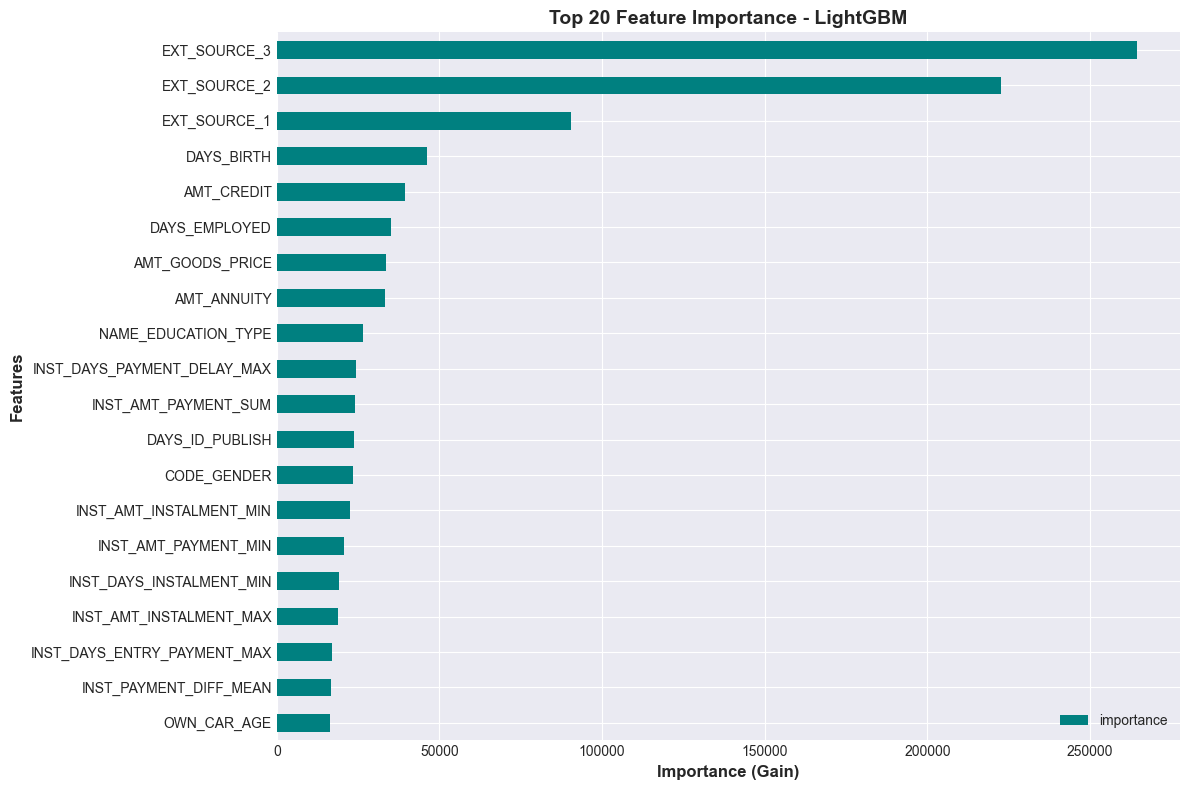

In [23]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20))

# Plot feature importance
fig, ax = plt.subplots(figsize=(12, 8))
feature_importance.head(20).plot(x='feature', y='importance', kind='barh', ax=ax, color='teal')
ax.set_xlabel('Importance (Gain)', fontsize=12, fontweight='bold')
ax.set_ylabel('Features', fontsize=12, fontweight='bold')
ax.set_title('Top 20 Feature Importance - LightGBM', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 8. Cross-Validation for Robust Evaluation

In [24]:
# 5-Fold Cross-Validation with LightGBM
print("Performing 5-Fold Cross-Validation...")

cv_scores = []
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train), 1):
    print(f"\nFold {fold}:")
    
    X_tr_fold = X_train.iloc[train_idx]
    X_val_fold = X_train.iloc[val_idx]
    y_tr_fold = y_train.iloc[train_idx]
    y_val_fold = y_train.iloc[val_idx]
    
    # Create datasets
    lgb_train_fold = lgb.Dataset(X_tr_fold, y_tr_fold)
    lgb_val_fold = lgb.Dataset(X_val_fold, y_val_fold, reference=lgb_train_fold)
    
    # Train
    lgbm_cv = lgb.train(
        lgbm_params,
        lgb_train_fold,
        num_boost_round=1000,
        valid_sets=[lgb_train_fold, lgb_val_fold],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=0)  # Silent
        ]
    )
    
    # Predict
    y_pred_fold = lgbm_cv.predict(X_val_fold, num_iteration=lgbm_cv.best_iteration)
    fold_score = roc_auc_score(y_val_fold, y_pred_fold)
    cv_scores.append(fold_score)
    
    print(f"  ROC AUC: {fold_score:.4f}")

print(f"\n{'='*80}")
print(f"Cross-Validation Results:")
print(f"  Mean ROC AUC: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")
print(f"  All fold scores: {[f'{s:.4f}' for s in cv_scores]}")
print(f"{'='*80}")

Performing 5-Fold Cross-Validation...

Fold 1:
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[321]	train's auc: 0.832786	valid's auc: 0.768015
  ROC AUC: 0.7680

Fold 2:
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[419]	train's auc: 0.845871	valid's auc: 0.775988
  ROC AUC: 0.7760

Fold 3:
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[322]	train's auc: 0.833311	valid's auc: 0.768932
  ROC AUC: 0.7689

Fold 4:
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[285]	train's auc: 0.826094	valid's auc: 0.773437
  ROC AUC: 0.7734

Fold 5:
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[313]	train's auc: 0.831655	valid's auc: 0.766508
  ROC AUC: 0.7665

Cross-Validation Results:
  Mean ROC AUC: 0.7706 (+/- 0.0036)
  All fold scores: ['0.7680', '0.7

## 9. Final Predictions on Test Set

In [25]:
# Train final model on full training data
print("Training final model on full training data...")

lgb_train_full = lgb.Dataset(X_train, y_train)

final_model = lgb.train(
    lgbm_params,
    lgb_train_full,
    num_boost_round=lgbm.best_iteration,  # Use best iteration from validation
    valid_sets=[lgb_train_full],
    valid_names=['train'],
    callbacks=[lgb.log_evaluation(period=100)]
)

print("\nGenerating predictions on test set...")
test_predictions = final_model.predict(X_test, num_iteration=final_model.best_iteration)

# Create submission file
submission = pd.DataFrame({
    'SK_ID_CURR': test_ids,
    'TARGET': test_predictions
})

print(f"\nSubmission shape: {submission.shape}")
print(f"\nFirst few predictions:")
print(submission.head(10))

print(f"\nPrediction statistics:")
print(submission['TARGET'].describe())

Training final model on full training data...
[100]	train's auc: 0.785875
[200]	train's auc: 0.804912
[300]	train's auc: 0.819655

Generating predictions on test set...

Submission shape: (48744, 2)

First few predictions:
   SK_ID_CURR    TARGET
0      100001  0.289184
1      100005  0.597298
2      100013  0.178949
3      100028  0.254950
4      100038  0.582405
5      100042  0.384181
6      100057  0.149539
7      100065  0.348176
8      100066  0.095103
9      100067  0.434843

Prediction statistics:
count    48744.000000
mean         0.379920
std          0.213976
min          0.008282
25%          0.198684
50%          0.348735
75%          0.543761
max          0.945616
Name: TARGET, dtype: float64


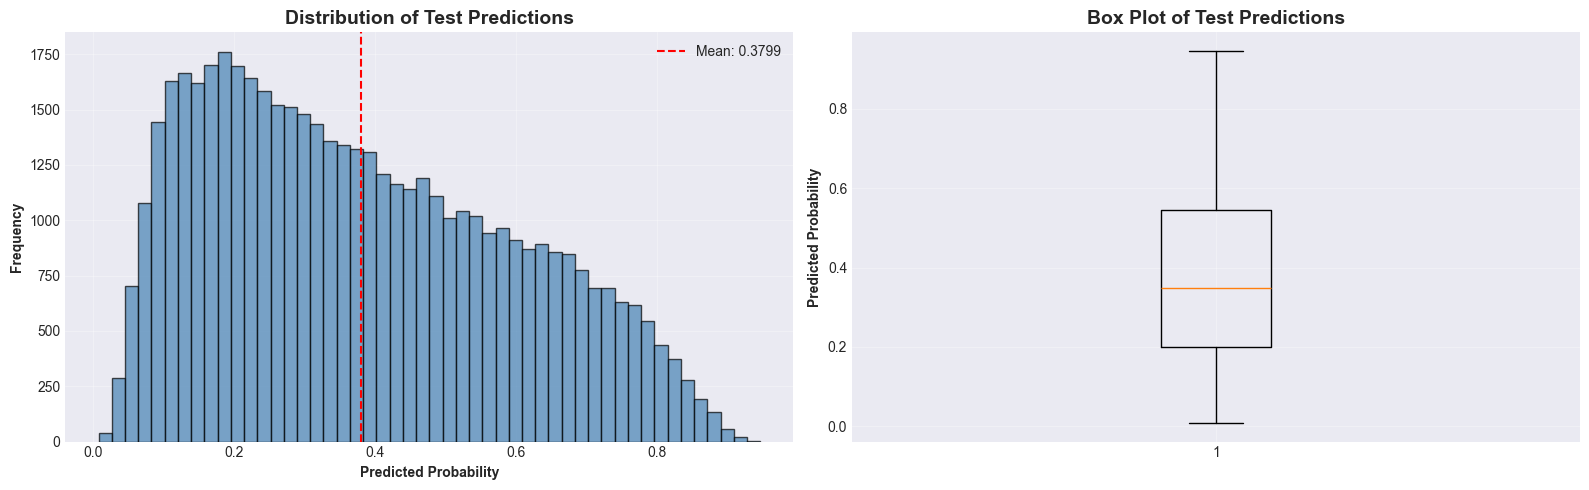


Prediction Range:
  Minimum: 0.008282
  Maximum: 0.945616
  Mean: 0.379920
  Median: 0.348735


In [26]:
# Visualize prediction distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histogram
axes[0].hist(submission['TARGET'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Predicted Probability', fontweight='bold')
axes[0].set_ylabel('Frequency', fontweight='bold')
axes[0].set_title('Distribution of Test Predictions', fontsize=14, fontweight='bold')
axes[0].axvline(submission['TARGET'].mean(), color='red', linestyle='--', 
                label=f'Mean: {submission["TARGET"].mean():.4f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
axes[1].boxplot(submission['TARGET'], vert=True)
axes[1].set_ylabel('Predicted Probability', fontweight='bold')
axes[1].set_title('Box Plot of Test Predictions', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Check prediction range
print(f"\nPrediction Range:")
print(f"  Minimum: {submission['TARGET'].min():.6f}")
print(f"  Maximum: {submission['TARGET'].max():.6f}")
print(f"  Mean: {submission['TARGET'].mean():.6f}")
print(f"  Median: {submission['TARGET'].median():.6f}")

In [27]:
from datetime import datetime

# Save submission file inside processed folder
submission_filename = f'../processed/submission_lightgbm_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'
submission.to_csv(submission_filename, index=False)

print(f"\nSubmission file saved: {submission_filename}")



Submission file saved: ../processed/submission_lightgbm_20260130_170206.csv


## 10. Model Insights for Business

Risk Segmentation Analysis:
               Count  Percentage
RISK_SEGMENT                    
Low Risk       17330   35.553094
High Risk      14546   29.841622
Medium Risk    13465   27.623913
Very Low Risk   3403    6.981372


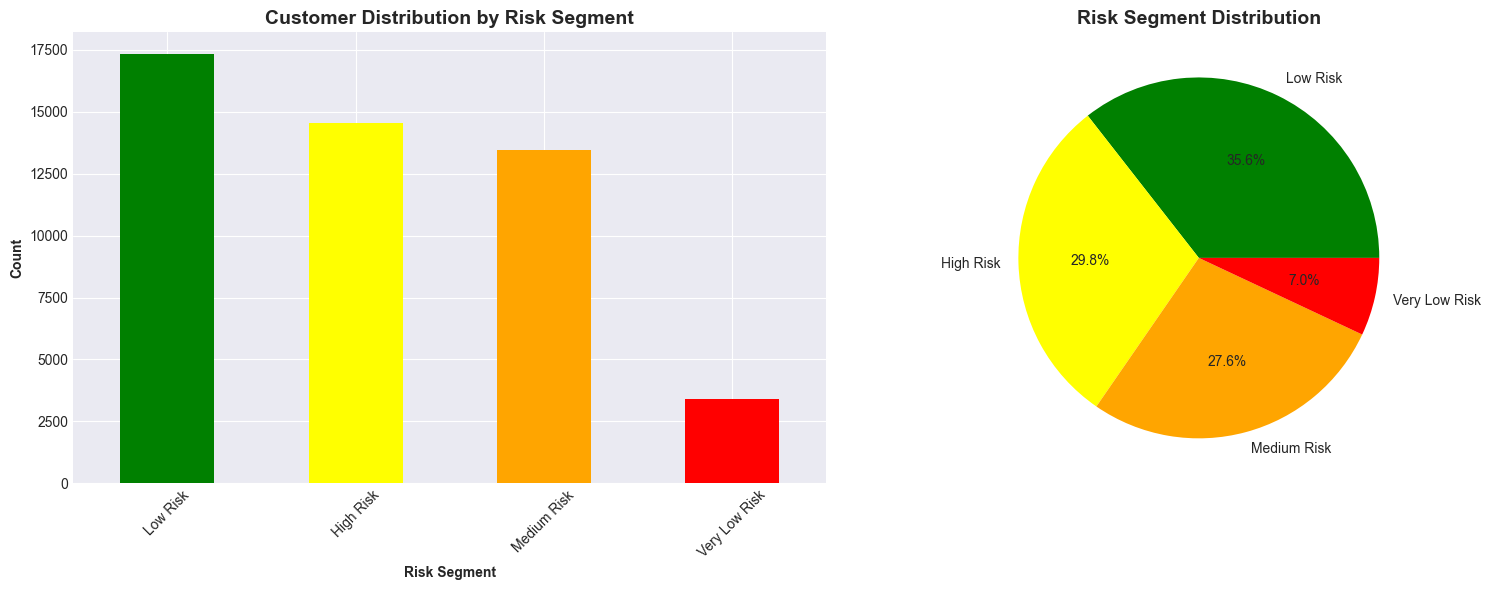

In [28]:
# Risk segmentation
def create_risk_segments(predictions, thresholds=[0.1, 0.3, 0.5]):
    """
    Segment customers by risk level
    """
    segments = []
    for pred in predictions:
        if pred < thresholds[0]:
            segments.append('Very Low Risk')
        elif pred < thresholds[1]:
            segments.append('Low Risk')
        elif pred < thresholds[2]:
            segments.append('Medium Risk')
        else:
            segments.append('High Risk')
    return segments

# Add risk segments to submission
submission['RISK_SEGMENT'] = create_risk_segments(submission['TARGET'])

# Analyze segments
segment_analysis = submission['RISK_SEGMENT'].value_counts()
segment_pct = submission['RISK_SEGMENT'].value_counts(normalize=True) * 100

print("Risk Segmentation Analysis:")
print("="*60)
segment_df = pd.DataFrame({
    'Count': segment_analysis,
    'Percentage': segment_pct
})
print(segment_df)

# Visualize segments
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
segment_analysis.plot(kind='bar', ax=axes[0], color=['green', 'yellow', 'orange', 'red'])
axes[0].set_title('Customer Distribution by Risk Segment', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Risk Segment', fontweight='bold')
axes[0].set_ylabel('Count', fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

# Pie chart
segment_analysis.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                      colors=['green', 'yellow', 'orange', 'red'])
axes[1].set_title('Risk Segment Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()